This notebook takes an image/text pair and runs our algorithms on them find the ideal landing point

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import gc
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import random
import copy
import torch
import torch.nn as nn
from torchvision import transforms as T
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

!pip install -q segmentation-models-pytorch
!pip install ftfy==5.9
!pip install omegaconf==2.0.5
import segmentation_models_pytorch as smp

# Clip Imports
os.chdir('/content/drive/MyDrive/DL-project/clip-training/')
from utils.simple_tokenizer import SimpleTokenizer
from omegaconf import OmegaConf
from model.model import CLIP
from utils import load_config_file

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.chdir('/content/drive/MyDrive/DL-project/DL_Full_Pipeline/')

     |████████████████████████████████| 102 kB 4.6 MB/s 
     |████████████████████████████████| 58 kB 5.9 MB/s 
     |████████████████████████████████| 376 kB 30.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 66 kB 2.4 MB/s 
  Created wheel for ftfy: filename=ftfy-5.9-py3-none-any.whl size=46467 sha256=f7cc7bc222b1dcb6eebb64eb529027cebcecd210b43f254e81a8fa99bb53f542
  Stored in directory: /root/.cache/pip/wheels/5c/d4/80/13a4398421dd85abb4320a7d735004241c586525783d002075
Successfully built ftfy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load Image/Text


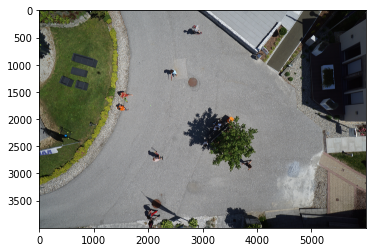

In [7]:
img_number = "002"
img_root = '/content/drive/MyDrive/DL-project/DL_Full_Pipeline/Images/'
img_path = img_root + img_number + ".jpg"
img = Image.open(img_path)
plt.imshow(img)

In [8]:
os.chdir('/content/drive/MyDrive/DL-project/clip-training/')
tokenizer = SimpleTokenizer()
def tokenize(text):
    sot_token = tokenizer.encoder["<|startoftext|>"]
    eot_token = tokenizer.encoder["<|endoftext|>"]
    tokens = [sot_token] + tokenizer.encode(text) + [eot_token]
    result = torch.zeros(77, dtype=torch.long)
    result[:len(tokens)] = torch.tensor(tokens)
    return result

text_com = "Red cross near a bicycle"
print(text_com)

token_com = tokenize(text_com)
print(token_com)
os.chdir('/content/drive/MyDrive/DL-project/DL_Full_Pipeline/')

Red cross near a bicycle
tensor([49406,   736,  3417,  2252,   320, 11652, 49407,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0])


# Semantic Segmentation Pipe

Query semantic segmentation model



In [9]:
# model_file = 'Unet-Mobilenet.pt'
model_file = 'DeepLabV3Plus-efficientnet.pt'
# model_file = 'fcn-efficientnet.pt'


if torch.cuda.is_available():
  model = torch.load(model_file)
else:
  model = torch.load(model_file, map_location=torch.device('cpu'))

model.eval()


DeepLabV3Plus(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSa

In [10]:
def predict_image(model, image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    with torch.no_grad():
        image = image.unsqueeze(0)       
        output = model(image)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked

img_pad = np.pad(img,((0,0),(8,8),(0,0)))
pred_mask = predict_image(model, img_pad)

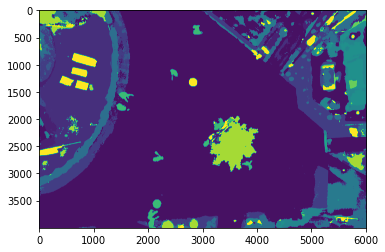

In [12]:
plt.imshow(pred_mask,cmap="viridis")

plt.savefig('/content/drive/MyDrive/DL-project/DL_Full_Pipeline/Pipeline_Results/' + img_number + 'semantic' + ".png")

Show ground truth

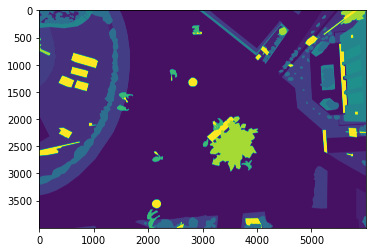

In [11]:
truth_root = '/content/drive/MyDrive/DL-project/DL_Full_Pipeline/Semantic_Maps_Gray/'
truth_path = truth_root + img_number + ".png"
sem = plt.imread(truth_path)
plt.imshow(sem)

Map semantic map output to safety map

safe = can land on

hazard = can land near

danger = don't land near

In [ ]:
labels = ['unlabeled', 'paved-area', 'dirt', 'grass', 'gravel', 'water', 'rocks', 'pool', 'vegetation', 'roof', 'wall', 'window', 'door', 
            'fence', 'fence-pole', 'person', 'dog', 'car', 'bicycle', 'tree', 'bald-tree', 'ar-marker', 'obstacle', 'conflicting']
safe_labels = ['paved-area', 'dirt', 'grass', 'gravel','roof','ar-marker'] # Blue
hazard_labels = ['rocks','vegetation','wall','window','door','fence','fence-pole','water','pool','tree','bald-tree','obstacle'] # Pink
danger_labels = ['unlabeled','person','dog','car','bicycle','conflicting'] # Yellow

safety_map = np.ones(pred_mask.shape)

safe_mask = (pred_mask == 1)|(pred_mask == 2)|(pred_mask == 3)|(pred_mask == 4)|(pred_mask == 9)|(pred_mask == 21)
danger_mask = (pred_mask == 0)|(pred_mask == 15)|(pred_mask == 16)|(pred_mask == 17)|(pred_mask == 18)|(pred_mask == 23)

safety_map[safe_mask] = 0
safety_map[danger_mask] = 2

plt.imshow(safety_map,cmap="plasma")

Denoise/smooth semantic segmentation for improved final results

In [ ]:
safety_map = safety_map.astype(np.uint8) # Has to be this for median blur

safety_map = cv2.medianBlur(safety_map, 15) # Use odd Kernel size
plt.imshow(safety_map,cmap="plasma")

plt.savefig('/content/drive/MyDrive/DL-project/DL_Full_Pipeline/Pipeline_Results/' + img_number + 'safety' + ".png")

# CLIP Pipe

Use location grid to create images with red crosses to be fed to clip

In [ ]:
def draw_red_cross(img, x, y, size=200):
  w,h = int(size/2),int(size/8)
  W,H = img.shape[0],img.shape[1]
  im = copy.deepcopy(img)
  im[max(0,x-w):min(W,x+w),max(0,y-h):min(H,y+h),0] = 255
  im[max(0,x-w):min(W,x+w),max(0,y-h):min(H,y+h),1] = 0
  im[max(0,x-w):min(W,x+w),max(0,y-h):min(H,y+h),2] = 0
  im[max(0,x-h):min(W,x+h),max(0,y-w):min(H,y+w),0] = 255
  im[max(0,x-h):min(W,x+h),max(0,y-w):min(H,y+w),1] = 0
  im[max(0,x-h):min(W,x+h),max(0,y-w):min(H,y+w),2] = 0
  return im


In [ ]:
size = 200
img_grid = []

img = np.array(img)

red_cross_map = copy.deepcopy(img)

for x in np.linspace(size,img.shape[0]-size,10):
  img_row = []
  for y in np.linspace(size,img.shape[1]-size,11):
    red_cross_map = draw_red_cross(red_cross_map,int(x),int(y))
    img_row.append(draw_red_cross(img,int(x),int(y)))
  img_grid.append(img_row)

In [ ]:
plt.imshow(red_cross_map)
plt.savefig('/content/drive/MyDrive/DL-project/DL_Full_Pipeline/Pipeline_Results/' + img_number + 'grid' + ".png")

Crop red cross images to work for clip (1400,1200) No padding

In [ ]:
crop_grid = []

i = 0
for x in np.linspace(size,img.shape[0]-size,10):
  j = 0
  crop_row = []
  for y in np.linspace(size,img.shape[1]-size,11):

    x_min = x - 700
    if x_min < 0:
      x_min = 0

    x_max = x + 700
    if x_max > 4000:
      x_max = 4000

    y_min = y - 600
    if y_min < 0:
      y_min = 0

    y_max = y + 600
    if y_max > 6000:
      y_max = 6000

    crop_row.append(img_grid[i][j][int(x_min):int(x_max),int(y_min):int(y_max),:])
    j += 1
  crop_grid.append(crop_row)
  i += 1

del img_grid

In [ ]:
plt.imshow(crop_grid[6][4])

Query CLIP

In [ ]:
def _transform(n_px):
    return T.Compose([
        T.Resize(n_px, interpolation=Image.BICUBIC),
        T.CenterCrop(n_px),
        lambda image: image.convert("RGB"),
        T.ToTensor(),
        T.Normalize((0.4225, 0.4012, 0.3659), (0.2681, 0.2635, 0.2763)), # COCO mean, std
    ])

def query_clip(text,img_grid):
  with torch.no_grad():
    os.chdir('/content/drive/MyDrive/DL-project/clip-training/')
    MODEL_CONFIG_PATH = 'model/model_config.yaml'

    model_config = load_config_file(MODEL_CONFIG_PATH)

    model_params = dict(model_config.RN50)
    model_params['vision_layers'] = tuple(model_params['vision_layers'])
    model_params['vision_patch_size'] = None
    model = CLIP(**model_params)
    if torch.cuda.is_available():
      checkpoint = torch.load('/content/drive/MyDrive/DL-project/clip-training/saved_checkpoints/checkpoint_19_900.pt')
    else:
      checkpoint = torch.load('/content/drive/MyDrive/DL-project/clip-training/saved_checkpoints/checkpoint_19_900.pt', map_location=torch.device('cpu'))
    state_dict = checkpoint['model_state_dict']
    model.load_state_dict(state_dict)
    if torch.cuda.is_available():
      model = model.to(torch.device(0))
    model.eval()

    scores = np.zeros((10,11))

    for x in range(10):
      for y in range(11):
        img = Image.fromarray(img_grid[x][y])
        img = _transform(224)(img)
        if torch.cuda.is_available():
          image_features, text_features = model(img.unsqueeze(0).cuda(), text.unsqueeze(0).cuda())
        else:
          image_features, text_features = model(img.unsqueeze(0), text.unsqueeze(0))
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        cos_sim = torch.nn.CosineSimilarity(dim=0)
        output = cos_sim(image_features[0], text_features[0])
        scores[x,y] = output.item()

  del model
  del state_dict
  del checkpoint
  del model_params
  del model_config
  del img
  del image_features
  del text_features
  del cos_sim
  del output
  gc.collect()
  # torch.cuda.empty_cache()

  return scores

scores = query_clip(token_com,crop_grid)

del crop_grid
del crop_row
del red_cross_map
del token_com

gc.collect()
torch.cuda.empty_cache()

Rank grid locations

In [ ]:
def topk(scores, k, axis=None):

    input = -1*scores
    ind = np.argpartition(input, k, axis=axis)
    ind = np.take(ind, np.arange(k), axis=axis) # k non-sorted indices
    input = np.take_along_axis(input, ind, axis=axis) # k non-sorted values

    # sort within k elements
    ind_part = np.argsort(input, axis=axis)
    ind = np.take_along_axis(ind, ind_part, axis=axis)
    input *= -1
    val = np.take_along_axis(input, ind_part, axis=axis) 
    return ind, val

ind,val = topk(scores,10)

max_ind = []
for index in ind:
  max_ind.append(np.unravel_index(index, scores.shape))

print("Max Indexes")
print(max_ind)
print("Max Scores")
print(val)

Display top k choices

In [ ]:
temp = Image.fromarray(img)
temp = temp.convert(" 
top_k_map = np.array(temp)

top_k_map[:,:] = [255,255,255,0]

top_k_circ = copy.deepcopy(top_k_map)

x = np.linspace(size,img.shape[0]-size,10)
y = np.linspace(size,img.shape[1]-size,11)

for i in range(len(val)):
  xind = max_ind[i][0]
  yind = max_ind[i][1]
  cv2.circle(top_k_circ,(int(y[yind]),int(x[xind])), 75, (140,255,0,255), -1)
  cv2.putText(top_k_map,str(i+1),(int(y[yind]-100),int(x[xind]+100)),cv2.FONT_HERSHEY_SIMPLEX,10,(0,255,0,255),50,cv2.LINE_AA)

plt.imshow(img)
plt.imshow(top_k_map)

plt.savefig('/content/drive/MyDrive/DL-project/DL_Full_Pipeline/Pipeline_Results/' + img_number + 'ranked' + ".png")

# Combine Pipes

Visualize two outputs on top of eachother

In [ ]:
plt.imshow(img)
plt.imshow(safety_map,alpha=0.7,cmap="plasma")
plt.imshow(top_k_circ)

plt.savefig('/content/drive/MyDrive/DL-project/DL_Full_Pipeline/Pipeline_Results/' + img_number + 'overlay' + ".png")

Choose location to feed to drone guidance system

Use scores from CLIP and safety heuristic

Landing zone size is the length of the landing zone bounding box given in pixels (would be found from landing zone size in real world distances and depth estimation maps)

In [ ]:
danger_level = []
lsz = 100 # landing zone size in pixels
rejection_threshold = 0.2
max_worry_distance = int(2*lsz) # How much larger than the lsz should the drone care about dangers/hazards

x = np.linspace(size,img.shape[0]-size,10)
y = np.linspace(size,img.shape[1]-size,11)

for i in range(len(val)):

  xi = int(x[max_ind[i][0]])
  yi = int(y[max_ind[i][1]])

  danger = 0
  
  # Check within landing bounding box for danger/hazard (Increase danger level enough to reject)
  if np.any(safety_map[xi-lsz:xi+lsz,yi-lsz:yi+lsz] >= 1):
    danger += 1

  # Check for sequentially larger boxes until hazard and danger is found

  hazard_found = 0
  danger_found = 0

  for j in range(lsz,max_worry_distance,5):

    if hazard_found == 0:
      if np.any(safety_map[xi-j:xi+j,yi-j:yi+j] >= 1):
        hazard_found = 1
        danger += 1 - (j/max_worry_distance)**(0.25)  # hazards punished less than dangers. Thus power of 0.25
        
    if danger_found == 0:
      if np.any(safety_map[xi-j:xi+j,yi-j:yi+j] == 2):
        danger_found = 1
        danger += 1 - (j/max_worry_distance)**(0.5) # hazards punished less than dangers. Thus power of 0.5

    if (hazard_found == 1) & (danger_found == 1):
      break # break early to save time

  danger_level.append(danger)

safety_adjusted_scores = val - danger_level

print("CLIP raw scores:")
print(val)
print(" ")
print("Safety adjusted scores:")
print(safety_adjusted_scores)
print(" ")

print("Max Score")
print(max(safety_adjusted_scores))
print(" ")

if max(safety_adjusted_scores) <= rejection_threshold:
  print("No suitable landing zone found!")
else:
  land_ind = max_ind[np.argmax(safety_adjusted_scores)]
  print("Landing Index:")
  print(land_ind)
  land_loc = (int(x[land_ind[0]]),int(y[land_ind[1]]))
  print(" ")
  print("Landing Pixel Location:")
  print(land_loc)

Plot final landing location

In [ ]:
land_img = copy.deepcopy(img)

cv2.circle(land_img,(land_loc[1],land_loc[0]), 100, (0,255,0), -1)
land_img = draw_red_cross(land_img,land_loc[0],land_loc[1])

plt.imshow(land_img)

plt.savefig('/content/drive/MyDrive/DL-project/DL_Full_Pipeline/Pipeline_Results/' + img_number + 'final' + ".png")